In [14]:
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
import os
import numpy as np
from hp import *
from utils import *
from keras import initializers

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def fit_func(params, data_path, fast):
    data = load_data(data_path)
    train_data = (data["x_train"], data["y_train"])
    val_data = (data["x_test"], data["y_test"])

    model_type = params["model_type"]
    model_kwargs = get_model_kwargs(model_type)
    params = {**params, **model_kwargs}

    x_args = params.pop("net_x_arch_trunk_args")
    params["net_x_arch_trunk"] = relu_network(
        [x_args["x_units"]] * x_args["x_layers"], dropout=x_args["dropout"]
    )
    y_args = params.pop("net_y_size_trunk_args")
    params["net_y_size_trunk"] = nonneg_tanh_network(
        [y_args["y_base_units"]] * y_args["y_layers"] + [y_args["y_top_units"]],
        dropout=y_args["dropout"], **y_args["kwargs"]
    )

    seed = params.pop("seed")
    set_seeds(seed)

    hist, neat_model = fit(
        epochs=20 if fast else 10_000,
        # epochs=20,
        train_data=train_data,
        val_data=val_data,
        **params,
    )
    return neat_model, hist

# Train "large" model with RandomUniform(0,1) initialisation

In [16]:
data_path = "energy"
hp_param = {
            "seed": 1,
            "net_x_arch_trunk_args": {
                "x_units": 20,
                "x_layers": 1,
                "dropout": 0,
            },
            "net_y_size_trunk_args": {
                "y_base_units": 100,
                "y_layers": 2,
                "y_top_units": 20,
                "dropout": 0.0,
                "kwargs": dict(kernel_initializer=initializers.RandomUniform(minval=0., maxval=1.))
                # "kwargs": dict(kernel_initializer=constraint_xavier_init)
            },
            "optimizer": Adam(learning_rate=1e-3),
            "base_distribution": tfd.Normal(loc=0, scale=1),
            "model_type": ModelType.LS,
        }

neat_model, hist = fit_func(hp_param, data_path, fast=False)

Epoch 1/10000


/home/daniel/miniconda3/envs/py10/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


22/22 [==============================] - 1s 7ms/step - logLik: 1631.9300 - val_logLik: 622.3953
Epoch 2/10000
22/22 [==============================] - 0s 2ms/step - logLik: 1228.7109 - val_logLik: 491.2485
Epoch 3/10000
22/22 [==============================] - 0s 2ms/step - logLik: 1010.1804 - val_logLik: 413.4966
Epoch 4/10000
22/22 [==============================] - 0s 2ms/step - logLik: 877.3518 - val_logLik: 363.6732
Epoch 5/10000
22/22 [==============================] - 0s 2ms/step - logLik: 792.3923 - val_logLik: 330.1674
Epoch 6/10000
22/22 [==============================] - 0s 2ms/step - logLik: 733.7495 - val_logLik: 307.3523
Epoch 7/10000
22/22 [==============================] - 0s 2ms/step - logLik: 694.7427 - val_logLik: 291.7884
Epoch 8/10000
22/22 [==============================] - 0s 2ms/step - logLik: 667.3255 - val_logLik: 280.8344
Epoch 9/10000
22/22 [==============================] - 0s 2ms/step - logLik: 648.6714 - val_logLik: 273.1802
Epoch 10/10000
22/22 [========

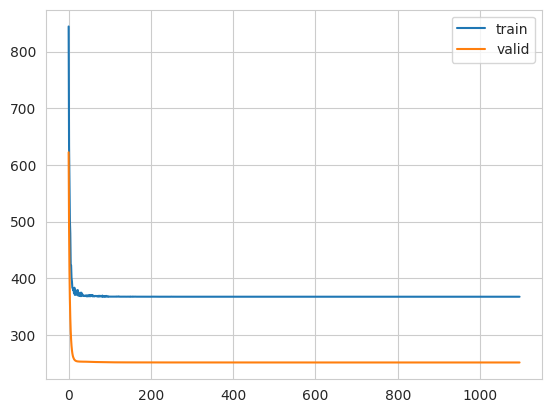

In [17]:
plt.plot(hist.history['logLik'], label='train')
plt.plot(hist.history['val_logLik'], label='valid')
plt.legend()

### plot transformation function

4/4 [==============================] - 0s 901us/step


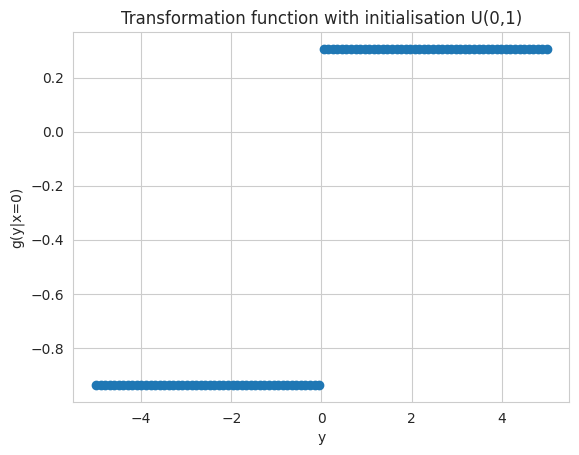

In [18]:
yy = np.linspace(-5,5,100)
xx = np.zeros((yy.shape[0], 8))
z = neat_model.predict((xx,yy))
plt.title("Transformation function with initialisation U(0,1)")
plt.xlabel("y")
plt.ylabel("g(y|x=0)")
plt.scatter(yy, z)
plt.savefig("images/initialisation_u(01).pdf")

# Train "large" model with abs(XavierInitialisation) initialisation

In [48]:
data_path = "energy"
hp_param['net_y_size_trunk_args']['kwargs'] = dict(kernel_initializer=constraint_xavier_init)
hp_param['net_y_size_trunk_args']['y_layers'] = 2
neat_model, hist = fit_func(hp_param, data_path, fast=False)

Epoch 1/10000
22/22 [==============================] - 1s 16ms/step - logLik: 235.2942 - val_logLik: 25.8976
Epoch 2/10000
22/22 [==============================] - 0s 2ms/step - logLik: 52.8301 - val_logLik: 14.4948
Epoch 3/10000
22/22 [==============================] - 0s 2ms/step - logLik: 40.5789 - val_logLik: 13.2632
Epoch 4/10000
22/22 [==============================] - 0s 2ms/step - logLik: 35.4191 - val_logLik: 11.3307
Epoch 5/10000
22/22 [==============================] - 0s 2ms/step - logLik: 30.7844 - val_logLik: 9.9116
Epoch 6/10000
22/22 [==============================] - 0s 2ms/step - logLik: 27.0566 - val_logLik: 8.7364
Epoch 7/10000
22/22 [==============================] - 0s 2ms/step - logLik: 24.0627 - val_logLik: 7.4057
Epoch 8/10000
22/22 [==============================] - 0s 2ms/step - logLik: 21.2754 - val_logLik: 6.3943
Epoch 9/10000
22/22 [==============================] - 0s 2ms/step - logLik: 18.6323 - val_logLik: 5.4273
Epoch 10/10000
22/22 [==================

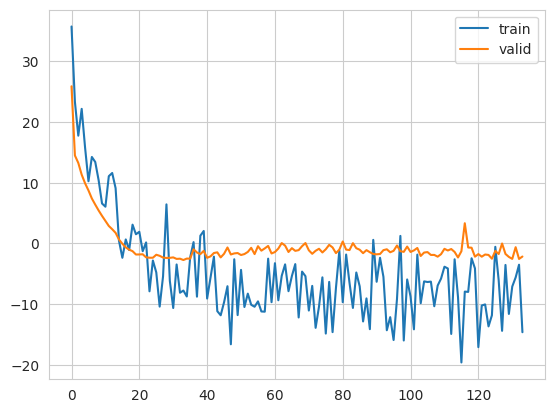

In [49]:
plt.plot(hist.history['logLik'], label='train')
plt.plot(hist.history['val_logLik'], label='valid')
plt.legend()

## plot transformation function
This weight initialization does function and our NN converged

4/4 [==============================] - 0s 842us/step


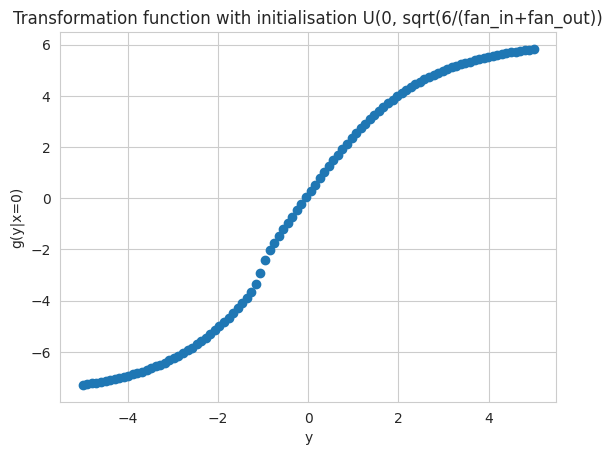

In [50]:
yy = np.linspace(-5,5,100)
xx = np.zeros((yy.shape[0], 8))
z = neat_model.predict((xx,yy))
plt.title("Transformation function with initialisation U(0, sqrt(6/(fan_in+fan_out))")
plt.xlabel("y")
plt.ylabel("g(y|x=0)")
plt.scatter(yy, z)
plt.savefig("images/initialisation_xavier_uniform+.pdf")

 we also see that the data is almost transformed into a Normal distribution

22/22 [==============================] - 0s 743us/step


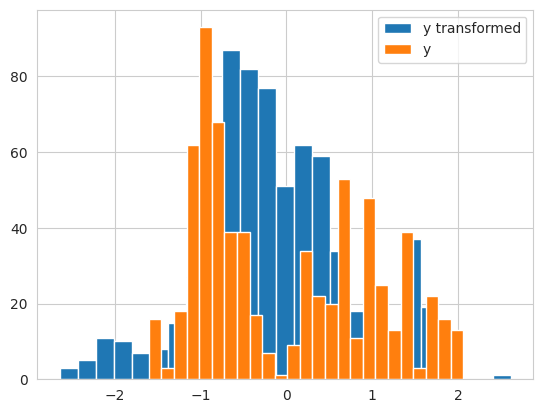

In [51]:
yy = load_data(data_path)['y_train']
xx = load_data(data_path)['x_train']
z = neat_model.predict((xx,yy))
plt.hist(z, bins=25, label="y transformed")
plt.hist(load_data(data_path)['y_train'], bins=25, label="y")
plt.legend()

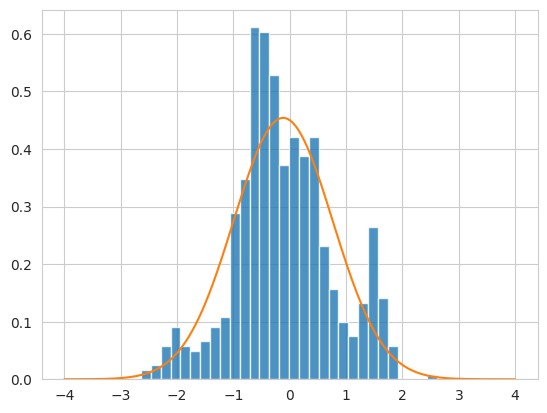

In [52]:
from scipy import stats
num_bins=30
plt.hist(z, bins=num_bins, alpha=0.8, density=True)

yy = np.linspace(-4, 4, 1000)
bin_width = (z.max() - z.min()) / num_bins
plt.plot(yy, stats.norm(z.mean(), z.std()).pdf(yy))

# Train realy large model (y_net = 100 neurons with 10 Layers) and with abs(XavierInitialisation) initialisation

In [31]:
def constraint_xavier_p_init(shape, dtype=None):
    fan_in = shape[1]
    fan_out = shape[0]
    limit = np.sqrt(6. / (fan_out**2))
    return tf.random.uniform(shape, minval=0., maxval=2*limit, dtype=dtype)

def constraint_xavier_p_bias(shape, dtype=None):
    # fan_in = shape[1]
    fan_out = shape[0]
    limit = np.sqrt(6. / (fan_out**2))
    limit = tf.convert_to_tensor(-limit, dtype=dtype)
    return tf.fill(shape, limit)

In [32]:
data_path = "energy"
hp_param['net_y_size_trunk_args']['kwargs'] = dict(kernel_initializer=constraint_xavier_p_init,
                                                   bias_initializer=constraint_xavier_p_bias)
hp_param['net_y_size_trunk_args']['y_layers'] = 10
neat_model, hist = fit_func(hp_param, data_path, fast=False)

Epoch 1/10000
22/22 [==============================] - 1s 11ms/step - logLik: 261.9495 - val_logLik: 19.7124
Epoch 2/10000
22/22 [==============================] - 0s 3ms/step - logLik: 58.2090 - val_logLik: 13.9730
Epoch 3/10000
22/22 [==============================] - 0s 3ms/step - logLik: 41.2214 - val_logLik: 11.5957
Epoch 4/10000
22/22 [==============================] - 0s 3ms/step - logLik: 33.1512 - val_logLik: 10.9735
Epoch 5/10000
22/22 [==============================] - 0s 3ms/step - logLik: 28.1187 - val_logLik: 8.3065
Epoch 6/10000
22/22 [==============================] - 0s 3ms/step - logLik: 22.6341 - val_logLik: 8.0267
Epoch 7/10000
22/22 [==============================] - 0s 3ms/step - logLik: 20.1813 - val_logLik: 7.4766
Epoch 8/10000
22/22 [==============================] - 0s 3ms/step - logLik: 17.4903 - val_logLik: 8.0135
Epoch 9/10000
22/22 [==============================] - 0s 3ms/step - logLik: 16.4512 - val_logLik: 11.7552
Epoch 10/10000
22/22 [=================

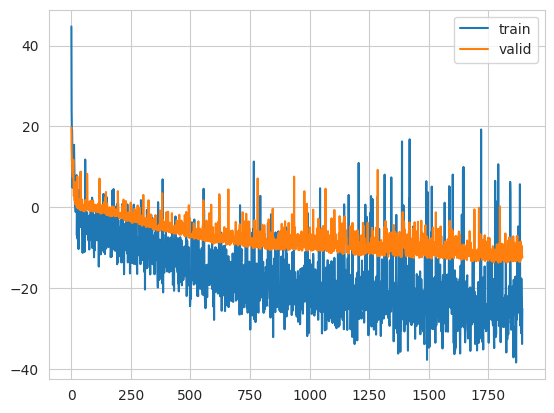

In [33]:
plt.plot(hist.history['logLik'], label='train')
plt.plot(hist.history['val_logLik'], label='valid')
plt.legend()

## plot transformation function
With this setting it still breaks

4/4 [==============================] - 0s 1ms/step


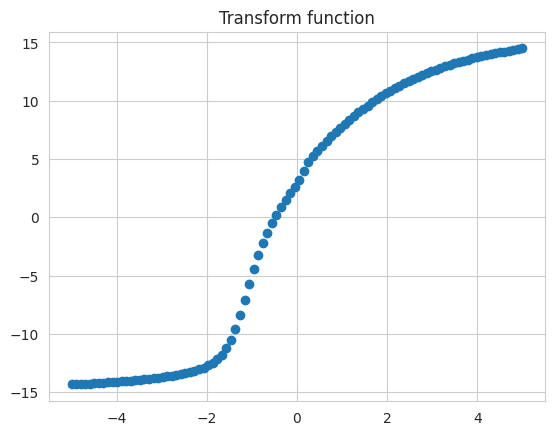

In [34]:
yy = np.linspace(-5,5,100)
xx = np.zeros((yy.shape[0], 8))
z = neat_model.predict((xx,yy))
plt.title("Transform function")
plt.scatter(yy, z)

22/22 [==============================] - 0s 948us/step


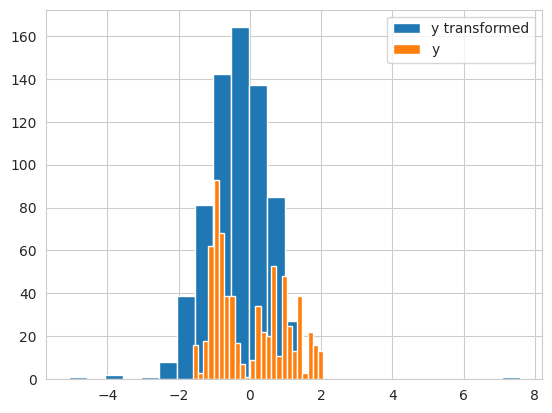

In [35]:
yy = load_data(data_path)['y_train']
xx = load_data(data_path)['x_train']
z = neat_model.predict((xx,yy))
plt.hist(z, bins=25, label="y transformed")
plt.hist(load_data(data_path)['y_train'], bins=25, label="y")
plt.legend()

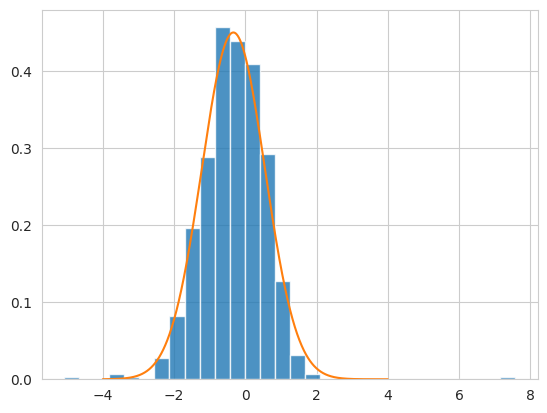

In [47]:
from scipy import stats
num_bins=30
plt.hist(z, bins=num_bins, alpha=0.8, density=True)

yy = np.linspace(-4, 4, 1000)
bin_width = (z.max() - z.min()) / num_bins
plt.plot(yy, stats.norm(z.mean(), z.std()).pdf(yy))